# Virtual Zarr store for ICON-CH1-EPS analysis data (KENDA-CH1)

This notebook demonstrates how to create a virtual Zarr store for the ICON-CH1-EPS analysis data (KENDA-CH1) using the VirtualiZarr library backed by Icechunk. It uses the parser implemented in this repository to read GRIB files and expose them as a Zarr store - without copying or converting any data.

In [1]:
from pathlib import Path
import os
import sys

definitions_path = Path(sys.prefix) / "share/eccodes-cosmo-resources/definitions"
os.environ["ECCODES_DEFINITION_PATH"] = str(definitions_path)

import dask
from obstore.store import LocalStore
import xarray as xr
from virtualizarr.registry import ObjectStoreRegistry
from virtualizarr import open_virtual_dataset

from icon_ch_vzarr import IconChParser

## Selecting the list of GRIB files to be indexed by the virtual Zarr store

The first step is to select a list of GRIB files to be indexed by the virtual Zarr store. In this example, we will use a full day of KENDA-CH1 analysis data.

In [2]:
DATA_DIR = "/store_new/mch/msopr/osm/KENDA-CH1/ANA25/det/"
files = sorted(Path(DATA_DIR).glob("iaf20250101*"))
urls = [f"file://{file}" for file in files]

print(f"Found {len(urls)} files")

Found 24 files


## Parsing the GRIB files into a manifest store

Next, we use the `IconChParser` to parse the selected GRIB files and create a manifest store. To learn more about this concept, please refer to the [VirtualiZarr documentation](https://virtualizarr.readthedocs.io/en/latest/data_structures.html).

In [3]:
store = LocalStore("/")
registry = ObjectStoreRegistry({"file://": store})

FILTERS = {"shortName": ["T", "T_2M","W","CLCL","TOT_PREC"]}
parser = IconChParser(filter_keys=FILTERS)

# TODO: remove print from /users/fzanetta/projects/icon-ch-vzarr/.venv/lib/python3.12/site-packages/earthkit/data/utils/batch.py:91
manifest_store = parser(urls[0], registry)
ds = xr.open_zarr(manifest_store, consolidated=False, decode_times=False, zarr_format=3)
ds

<xarray.Dataset> Size: 2GB
Dimensions:               (valid_time: 1, generalVertical: 81, values: 1147980,
                           generalVerticalLayer: 80)
Coordinates:
  * valid_time            (valid_time) datetime64[ns] 8B 2025-01-01
  * generalVertical       (generalVertical) float64 648B 1.0 2.0 ... 80.0 81.0
  * generalVerticalLayer  (generalVerticalLayer) float64 640B 1.0 2.0 ... 80.0
Dimensions without coordinates: values
Data variables:
    W                     (valid_time, generalVertical, values) float64 744MB dask.array<chunksize=(1, 1, 1147980), meta=np.ndarray>
    T                     (valid_time, generalVerticalLayer, values) float64 735MB dask.array<chunksize=(1, 1, 1147980), meta=np.ndarray>
    T_2M                  (valid_time, values) float64 9MB dask.array<chunksize=(1, 1147980), meta=np.ndarray>
    CLCL                  (valid_time, values) float64 9MB dask.array<chunksize=(1, 1147980), meta=np.ndarray>
    TOT_PREC              (valid_time, values) float64 9MB dask.array<chunksize=(1, 1147980), meta=np.ndarray>

In [4]:
from pprint import pprint
pprint(manifest_store._group.arrays["T_2M"].metadata)

ArrayV3Metadata(shape=(1, 1147980),
                data_type=Float64(endianness='little'),
                chunk_grid=RegularChunkGrid(chunk_shape=(1, 1147980)),
                chunk_key_encoding=DefaultChunkKeyEncoding(separator='/'),
                fill_value=np.float64(0.0),
                codecs=(EccodesCodec(),),
                attributes={'_earthkit': {'b64message': 'R1JJQv//AAIAAAAAAAAAqgAAABUBANcA/w8BAQfpAQEAAAABAQAAABwCAP4AB+kBAQIqJwAAAAAAAAAAAAAAAAEAAAAjAwAAEYRMAAAAZQYAAAEBF2Q9oldJWbZE0lSjzW4rwAAAACIEAAAAAAAAAgCXAAAAAAAAAABnAAAAAAL///////8AAAAVBQAAAfAAAEOIgACACgAAAAAAAAAGBv8AAAAFBzc3Nzc=',
                                          'bitsPerValue': 16},
                            'long_name': '2m Temperature',
                            'standard_name': 'air_temperature',
                            'units': 'K'},
                dimension_names=('valid_time', 'values'),
                zarr_format=3,
                node_type='array',
                storage_transformer

In [5]:
ds["T_2M"].values

array([[274.62667847, 274.99777222, 274.78097534, ..., 273.57931519,
        273.56271362, 273.53341675]], shape=(1, 1147980))

In [6]:
tasks = [dask.delayed(open_virtual_dataset)(url, registry, parser) for url in urls]
vds = dask.compute(*tasks, scheduler="processes")
vds = xr.combine_by_coords(vds, combine_attrs="override")
vds

<xarray.Dataset> Size: 36GB
Dimensions:               (valid_time: 24, generalVertical: 81,
                           values: 1147980, generalVerticalLayer: 80)
Coordinates:
  * valid_time            (valid_time) datetime64[ns] 192B 2025-01-01 ... 202...
  * generalVertical       (generalVertical) float64 648B 1.0 2.0 ... 80.0 81.0
  * generalVerticalLayer  (generalVerticalLayer) float64 640B 1.0 2.0 ... 80.0
Dimensions without coordinates: values
Data variables:
    W                     (valid_time, generalVertical, values) float64 18GB ...
    T                     (valid_time, generalVerticalLayer, values) float64 18GB ManifestArray<shape=(24, 80, 1147980), dtype=float64, chunks=(1, 1, 1147...
    T_2M                  (valid_time, values) float64 220MB ManifestArray<sh...
    CLCL                  (valid_time, values) float64 220MB ManifestArray<sh...
    TOT_PREC              (valid_time, values) float64 220MB ManifestArray<sh...

In [7]:
# TODO: persist the virtualized dataset using icechunk or kerchunk references
# could not get it to work yet

In [8]:
# vds.vz.to_kerchunk("references.json", format="json")

# xr.open_dataset("references.json", engine="kerchunk")["T_2M"].variable.values

In [7]:
import icechunk

try:
    del vds["generalVertical"].encoding["serializer"]
    del vds["generalVerticalLayer"].encoding["serializer"]
    del vds["valid_time"].encoding["serializer"]
except:
    print("No serializer to delete")
    pass

scheme = "file://"
prefix = Path.cwd() / "tmp"
# remove the directory if it exists
if prefix.exists():
    for item in prefix.iterdir():
        if item.is_file():
            item.unlink()
        elif item.is_dir():
            import shutil
            shutil.rmtree(item)
prefix.mkdir(parents=True, exist_ok=True)

output_path = f"{prefix}/icechunk/1/"
config = icechunk.RepositoryConfig.default()
container = icechunk.VirtualChunkContainer(
    url_prefix=f"{scheme}/store_new/",
    # url_prefix=f"{scheme}/",
    store=icechunk.local_filesystem_store(f"/"),
)
config.set_virtual_chunk_container(container)
icechunk_storage = icechunk.Storage.new_local_filesystem(output_path)
icechunk_repo = icechunk.Repository.create(
    storage=icechunk_storage,
    config=config,
    authorize_virtual_chunk_access={f"{scheme}{prefix}/": None},
)
session = icechunk_repo.writable_session("main")
vds.vz.to_icechunk(session.store)
session.commit("Test commit")


  2025-12-10T09:25:35.182030Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80



'VQGGS3G82RKBMZYCAR6G'

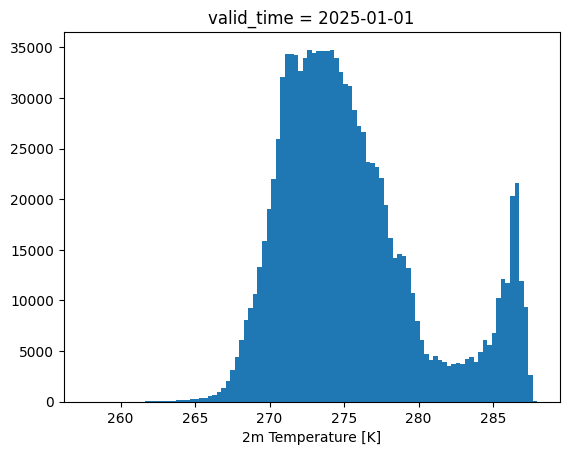

In [8]:
icechunk_repo = icechunk.Repository.open(
    storage=icechunk_storage,
    config=config,
    authorize_virtual_chunk_access={f"{scheme}/store_new/": None},
)
read_session = icechunk_repo.readonly_session("main")
ice_ds = xr.open_zarr(read_session.store, group="/", zarr_format=3, consolidated=False)
ice_ds["T_2M"][0].plot.hist(bins=100);

In [ ]:
ice_ds["CLCL"][0]

<xarray.Dataset> Size: 36GB
Dimensions:               (valid_time: 24, values: 1147980,
                           generalVertical: 81, generalVerticalLayer: 80)
Coordinates:
  * valid_time            (valid_time) datetime64[ns] 192B 2025-01-01 ... 202...
  * generalVertical       (generalVertical) float64 648B 1.0 2.0 ... 80.0 81.0
  * generalVerticalLayer  (generalVerticalLayer) float64 640B 1.0 2.0 ... 80.0
Dimensions without coordinates: values
Data variables:
    CLCL                  (valid_time, values) float64 220MB dask.array<chunksize=(1, 1147980), meta=np.ndarray>
    TOT_PREC              (valid_time, values) float64 220MB dask.array<chunksize=(1, 1147980), meta=np.ndarray>
    W                     (valid_time, generalVertical, values) float64 18GB dask.array<chunksize=(1, 1, 1147980), meta=np.ndarray>
    T_2M                  (valid_time, values) float64 220MB dask.array<chunksize=(1, 1147980), meta=np.ndarray>
    T                     (valid_time, generalVerticalLayer, values) float64 18GB dask.array<chunksize=(1, 1, 1147980), meta=np.ndarray>